# Numerical computing
* stability, convergence
* finite difference, finite volume, ENO/WENO, finite element, spectral, multigrid

## Forward Euler method

Consider the equation

$$\dot{u}(t) = f(u(t)).$$

It can be approximated by the forward Euler scheme

$$U^{n+1} = U^n + \Delta t f(U^n),$$

where $U^n := u(t_n)$ and $\Delta t = t_{n+1} - t_n$.
* Example 1
> $\dot{u} = -sin(t)$, $u(0) = 1$ with solution $u(t) = cos(t)$.

* Example 2
> $\dot{u} = \lambda (u - cos(t)) - sin(t)$, $u(0) = 1$ with solution $u(t) = cos(t)$.

In [4]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "/Users/brucelee/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/brucelee/opt/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [5]:
def Euler(U, t, dt, f):
    return U + dt * f(U, t)

In [6]:
T = 2  # stop time
dt = 0.001 # timestep

t = np.arange(0, T, dt)

U = np.zeros(len(t))

U[0] = 1 # initial data

In [7]:
f1 = lambda u, t: -np.sin(t)

for n in range(len(t)-1):
    U[n+1] = Euler(U[n], t[n], dt, f1)
    
u = np.cos(t)

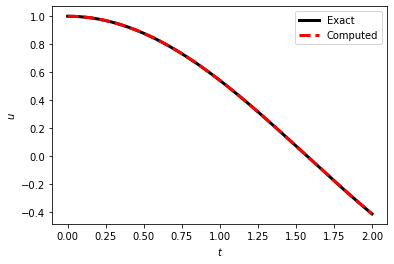

In [8]:
plt.clf()
plt.plot(t, u, 'k', t, U, 'r--', linewidth=3)
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.legend(['Exact', 'Computed'])
plt.show()

This approximated result is very close to the exact solution.

In [9]:
# error less than dt
print(abs(u[-1] - U[-1]))

0.00045497449591758166


In [10]:
T = 2  # stop time
dt = 0.001 # timestep

t = np.arange(0, T, dt)

U = np.zeros(len(t))

U[0] = 1 # initial data

In [11]:
f2 = lambda u, t: lambd * (u - np.cos(t)) -np.sin(t)

lambd = 2.0

for n in range(len(t)-1):
    U[n+1] = Euler(U[n], t[n], dt, f2)
    
u = np.cos(t)

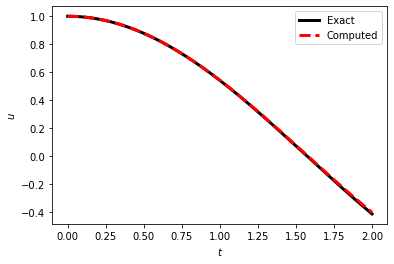

In [12]:
plt.clf()
plt.plot(t, u, 'k', t, U, 'r--', linewidth=3)
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.legend(['Exact', 'Computed'])
plt.show()

The evident error occurs in the later of the approximation.

In [13]:
print(abs(u[-1] - U[-1]))

0.011024968026736914


* Example 3: modeling a damped harmonic oscillator (e.g., a pendulum with friction under small amplitude oscillations)

> initial value problem
$$\ddot{u}(t) = -a u(t) - b \dot{u}(t)$$

> rewrite this as a first-order system
$$\frac{d}{dt} \begin{pmatrix}
u_1 \\ u_2
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 \\ -a & -b
\end{pmatrix}
\begin{pmatrix}
u_1 \\ u_2
\end{pmatrix}
$$

solve the equation symbolically and hence exactly using `SymPy`

In [14]:
import sympy as sym
from sympy.utilities import lambdify

sym.init_printing(use_latex=True)

In [15]:
t, a, b = sym.symbols('t a b')
u = sym.symbols('u', cls=sym.Function)

In [16]:
u(t)

In [17]:
eqn = u(t).diff(t, 2) + a * u(t) + b * u(t).diff(t)

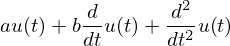

In [18]:
eqn

In [19]:
sol = sym.dsolve(eqn).args[1]
solp = sol.diff(t)

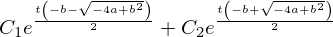

In [20]:
sol

In [21]:
sol1, sol1p = sol.subs({t:0, a:100, b:0}), solp.subs({t:0, a:100, b:0})

In [22]:
params = sym.solve((sol1-1, sol1p))

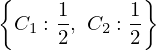

In [23]:
params

In [24]:
T = 2  # stop time
dt = 0.001 # timestep

t = np.arange(0, T, dt)

/Users/brucelee/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


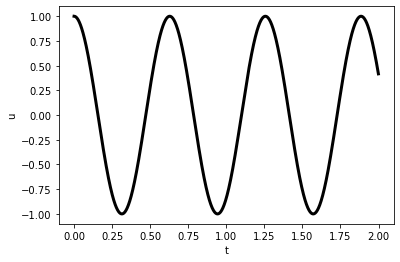

In [25]:
plt.figure()
plt.plot(t, (np.exp(-10*1j*t) + np.exp(10*1j*t)) / 2, 'k-', lw=3)
plt.xlabel('t')
plt.ylabel('u')
plt.show()

solve the equation numerically using `odeint`, then we observe that the result is very exact.

In [26]:
from scipy.integrate import odeint

In [27]:
def f(u, t):
    du = np.zeros(2)
    du[0] = u[1]
    du[1] = -a * u[0] - b * u[1]
    
    return du

a = 100; b = 0
# a = 100; b = 10

In [28]:
T = 2  # stop time
dt = 0.001 # timestep

t = np.arange(0, T, dt)

U0 = np.array([1., 0.])

U = odeint(f, U0, t)

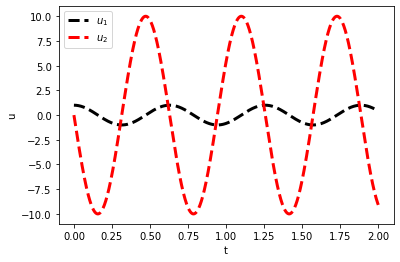

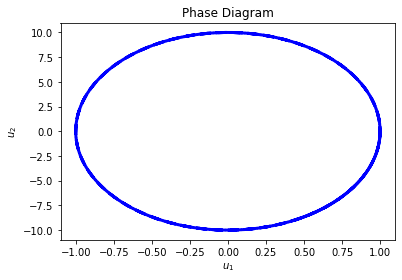

In [29]:
plt.figure()
plt.plot(t, U[:, 0], 'k--', label=r'$u_1$', lw=3)
plt.plot(t, U[:, 1], 'r--', label=r'$u_2$', lw=3)
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.show()

plt.figure()
plt.plot(U[:, 0], U[:, 1], 'b--', lw=3)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.title(r'Phase Diagram')
plt.show()

In [30]:
print(abs((np.exp(-10*1j*t[-1]) + np.exp(10*1j*t[-1])) / 2 - U[-1, 0]))

2.0060420613532415e-07


numerical methods by hand

In [31]:
def Euler(U, dt, f):
    return U + dt * f(U)

def midpoint(U, Uold, dt, f):
    # Uold is the previous step (U^{n-1})
    return Uold + 2 * dt * f(U)

In [32]:
T = 2  # stop time
dt = 0.001 # timestep

t = np.arange(0, T, dt)

U = np.zeros((len(t), 2))

U[0, 0] = 1; U[0, 1] = 0 # initial data

In [33]:
def f(u):
    du = np.zeros(2)
    du[0] = u[1]
    du[1] = -a * u[0] - b * u[1]
    
    return du

a = 100; b = 0
# a = 100; b = 10

for n in range(len(t)-1):
    U[n+1, :] = Euler(U[n, :], dt, f)

from the phase diagram, we know that this approximation is not accurate to some extent.

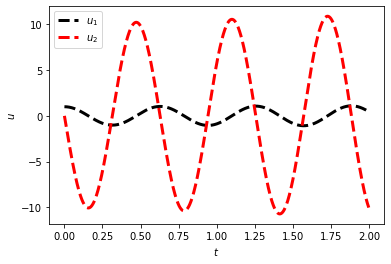

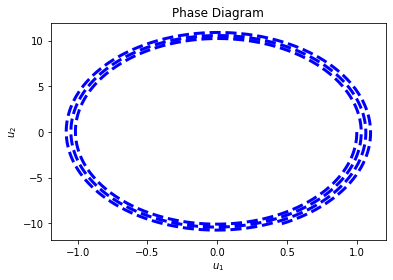

In [34]:
plt.figure()
plt.plot(t, U[:, 0], 'k--', t, U[:, 1], 'r--', linewidth=3)
plt.xlabel(r'$t$')
plt.ylabel(r'$u$')
plt.legend([r'$u_1$', r'$u_2$'])

plt.figure()
plt.plot(U[:, 0], U[:, 1], 'b--', linewidth=3)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.title(r'Phase Diagram')
plt.show()

In [35]:
print(abs((np.exp(-10*1j*t[-1]) + np.exp(10*1j*t[-1])) / 2 - U[-1, 0]))

0.04452008535457008


##  Heat equation

### numerical schemes

* Leapfrog

In [36]:
import numpy as np

import matplotlib.pyplot as plt

In [37]:
nx = 41
dx = 2. / (nx-1)

x = np.linspace(0, 2, nx)

u = np.ones(nx)
u[int(.5 / dx):int(1/dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s

steps = 20

nu = 0.3   #the value of viscosity
sigma = .2 #sigma is a parameter
dt = sigma * dx**2 / nu #dt is defined using sigma

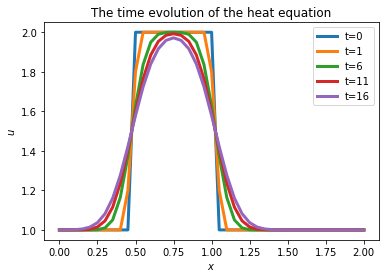

In [38]:
un = np.ones(nx) #our placeholder array, un, to advance the solution in time

fig = plt.figure()
plt.plot(x, u, linewidth=3, label="t=%d"%0)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The time evolution of the heat equation')
for j in range(steps):
    un = u.copy()
    for i in range(1, nx - 1):
        u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2*un[i] + un[i-1])
    if j%5 == 0:
        plt.plot(x, u, linewidth=3, label="t=%d"%(j+1))

plt.legend()
plt.show()

In [1]:
#%matplotlib inline
%matplotlib notebook
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
nx = 41
dx = 2. / (nx-1)

x = np.linspace(0, 2, nx)

u = np.ones(nx)
u[int(.5 / dx):int(1/dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s

steps = 20

nu = 0.3   #the value of viscosity
sigma = .2 #sigma is a parameter
dt = sigma * dx**2 / nu #dt is defined using sigma

In jupyter notebook, implementing animation using `%matplotlib notebbok`.

<IPython.core.display.Javascript object>


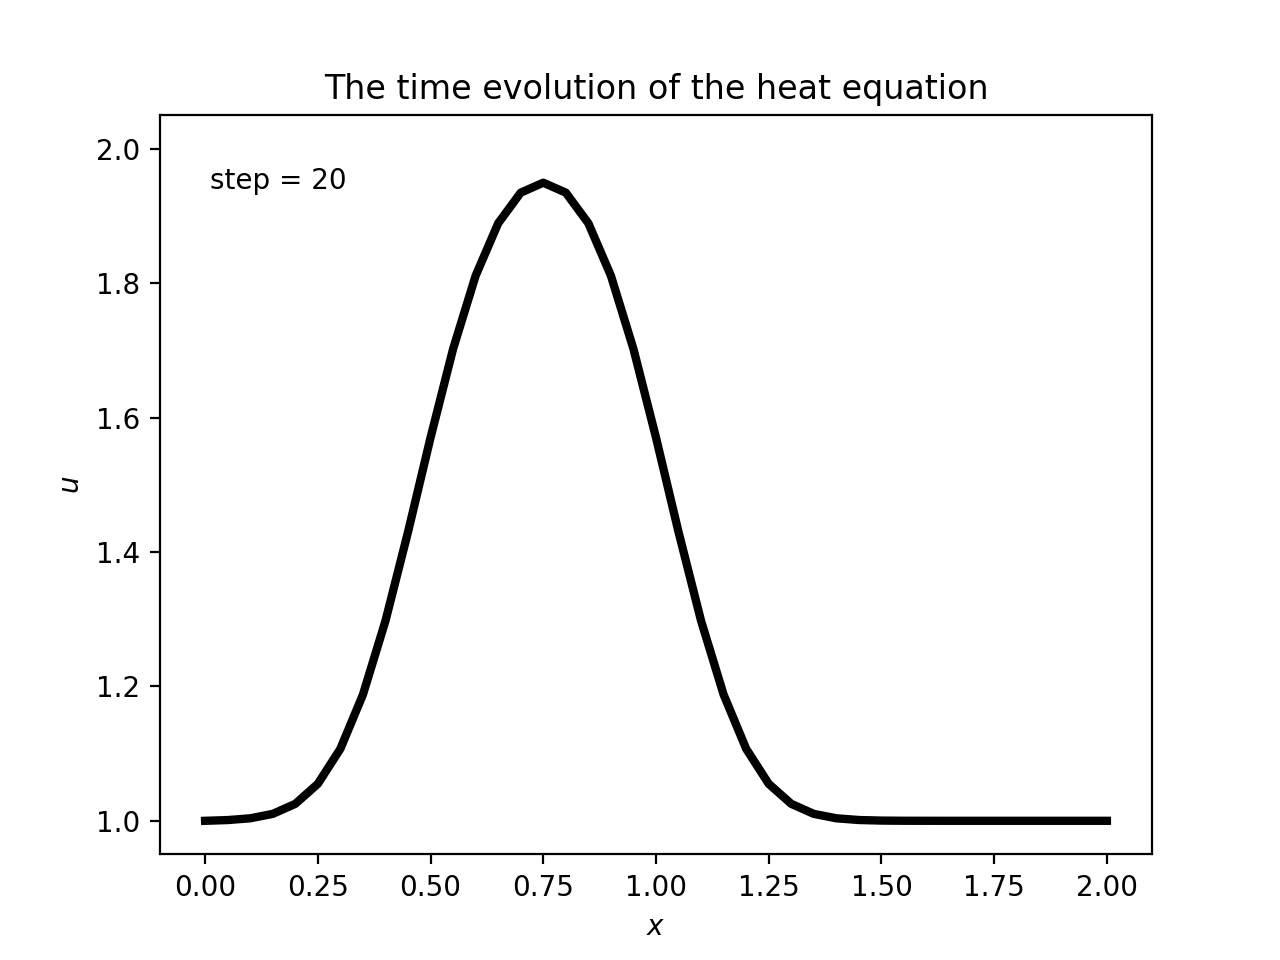

In [3]:
uu = np.ones((steps+1, nx))
uu[0, :] = u

for j in range(steps):
    for i in range(1, nx - 1):
        u[i] = uu[j, i] + nu * dt / dx**2 * (uu[j, i+1] - 2*uu[j, i] + uu[j, i-1])
    
    uu[j+1, :] = u
    
fig, ax = plt.subplots()
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The time evolution of the heat equation')

line, = ax.plot(x, uu[0, :], 'k-', linewidth=3)

time_template = 'step = %d'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def animate(j):
    line.set_ydata(uu[j, :])
    time_text.set_text(time_template % (j))
    
    return line, time_text

def init():
    line.set_ydata(uu[0, :])
    
    return line, time_text

ani = animation.FuncAnimation(fig=fig, func=animate, frames=steps+1, init_func=init, interval=100, blit=False, repeat=False)

plt.show()

* Crank-Nicolson approximation

In [39]:
%matplotlib inline
import numpy as np
from scipy.sparse import spdiags, linalg, diags, eye

import matplotlib.pyplot as plt

In [40]:
def A_matrix(m):
    "Centered 3-point approximation of the 2nd derivative on a grid with m+2 points, with Dirichlet boundary conditions."
    
    h = 1. / (m+1)
    
    e0 = -2. / h**2 * np.ones(m+2); e0[0] = 1.; e0[-1] = 1.
    e1 = 1. / h**2 * np.ones(m+1); e1[0] = 0.
    em1 = 1. / h**2 * np.ones(m+1); em1[-1] = 0.
    
    A = diags([em1, e0, e1], [-1, 0, 1])
    
    return A

def heat_CN(T, m):
    r"""Compute solution to the heat equation at time T with m grid points."""
    
    h = 1. / (m+1)
    k = h

    M1 = eye(m+2, m+2) - k/2. * A_matrix(m)
    M2 = eye(m+2, m+2) + k/2. * A_matrix(m)

    x = np.linspace(0, 1, m+2)
    
    beta = 100.
    U = np.exp(- (x-0.4)**2 / (1./beta))  # Initial data

    t = 0. # Initial time
    
    steps = int(round(T / k))
    if np.abs(k*steps - T) > 1.e-5:
        print('Warning: k does not divide T: k=%.2f' % k)

    for _ in range(steps):
        t = t + k
        b = M2.dot(U)
        U = linalg.spsolve(M1, b)
    return x, U

In [41]:
x, U = heat_CN(0., 199)

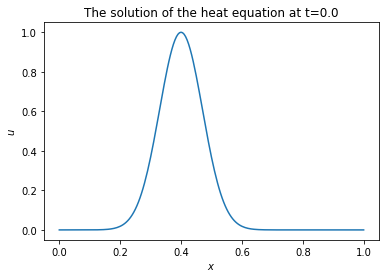

In [42]:
plt.figure()
plt.plot(x, U)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The solution of the heat equation at t=%.1f'%0)
plt.show()

In [43]:
x, U = heat_CN(0.1, 199)

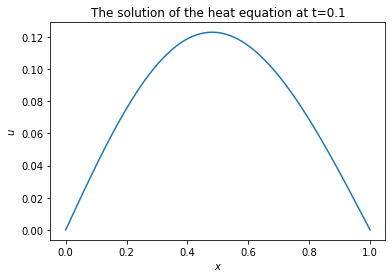

In [44]:
plt.figure()
plt.plot(x, U)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The solution of the heat equation at t=%.1f'%0.1)
plt.show()

### different boundary conditions

$$u_t(x, t) = \kappa u_{xx}(x, t) + \Psi(x)$$

* Example 1: Dirichlet condition
$$u_{xx}(x, t) = f(x), 0 \le x \le 1, \\ u(0) = a, u(1) = b,$$

where the values $a$, $b$ correspond to the fixed temperatures at the end of the rod, respectively and $f(x)=-\Psi(x)/\kappa$.

Then the equation can be solved by the approximation

$$u_{xx}(x, t) \approx \frac{U_{i-1} - 2 U_i + U_{i+1}}{h^2} = AU.$$

In [45]:
def D(m):
    "Centered 3-point approximation of the 1st derivative on a grid with m points, with homogeneous Dirichlet boundary conditions."
    
    h = 1. / (m+1)
    
    e_mp2 = np.ones(m+2)
    e_mp1 = np.ones(m+1)
    
    A = 1./h * (-np.diag(e_mp1, -1) + np.diag(e_mp1, 1))
    
    A[0,0]=0.
    A[0,1]=0.
    A[-1,-1]=0.
    A[-1,-2]=0.
    
    return A

def D2(m):
    "Centered 3-point approximation of the 2nd derivative on a grid with m points, with Dirichlet boundary conditions."
    
    h = 1. /(m+1)
    
    e_mp2 = np.ones(m+2)
    e_mp1 = np.ones(m+1)
    
    A = 1. / h**2 * (np.diag(e_mp1, -1) - 2 * np.diag(e_mp2, 0) + np.diag(e_mp1, 1))
    
    A[0,0] = 0.
    A[0,1] = 0.
    A[-1,-1] = 0.
    A[-1,-2] = 0.
    
    return A

def Dirichlet_BC(m):
    "Boundary conditions matrix."
    
    A = np.zeros((m+2, m+2))
    
    A[0, 0] = 1.
    A[-1, -1] = 1.
    
    return A

def f(x):
    
    #return np.zeros(x.shape)
    #return np.sin(np.exp(5*x))
    return -np.ones(x.shape)

def rhs(f, x, alpha, beta):
    F = f(x)
    
    F[0]  = alpha
    F[-1] = beta
    
    return F

In [46]:
m = 1000

alpha = 1.
beta = 0.

x = np.linspace(0, 1, m+2)

A = D2(m) + Dirichlet_BC(m)
F = rhs(f, x, alpha, beta)

U = np.linalg.solve(A, F)

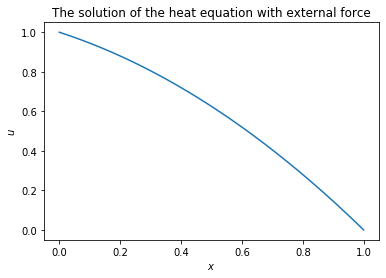

In [47]:
plt.figure()
plt.plot(x, U)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The solution of the heat equation with external force')
plt.show()

* Example 2 : Neumann boundary condition

$$u''(x, t) = -1, 0 \le x \le 1, \\ u'(0) = a, u(1) = b.$$

In [48]:
def Neumann_BC_left(m):
    "Boundary conditions matrix."
    
    h = 1. /(m+1)
    
    A = np.zeros((m+2, m+2))
    
    A[0, 0] = - 1./h
    A[0, 1] =  1./h
    
    return A

def Dirichlet_BC_right(m):
    A = np.zeros((m+2, m+2))
    
    A[-1, -1] = 1
    
    return A
    
def rhs(f, x, alpha, beta):
    F = f(x)
    
    F[0]  = alpha
    F[-1] = beta
    
    return F

In [49]:
m = 1000

alpha = 0.
beta = 0.

x = np.linspace(0, 1, m+2)

A = D2(m) + Dirichlet_BC_right(m) + Neumann_BC_left(m)
F = rhs(f, x, alpha, beta)

U = np.linalg.solve(A, F)

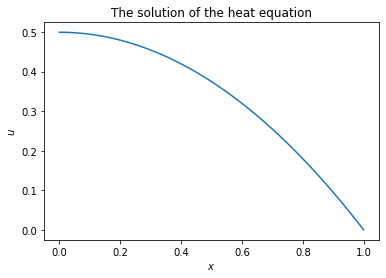

In [50]:
plt.figure()
plt.plot(x, U)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The solution of the heat equation')
plt.show()

## Lighthill-Whitham-Richards(or LWR) Traffic flow model

The continuity equation is given by

$$q_t + (u q)_x = 0$$

where $q$ and $u$ denote the density of cars on a road and the traveling velocity, respectively.

Cars go faster in light traffic and slower when there is congestion. The simplest way to incorporate this effect is to make the velocity a linearly decreasing function of the density

$$u(q) = 1 - q.$$

Then the conservation law is obtained

$$q_t + \left(q (1 - q)\right)_x = 0.$$

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.size'] = 15

In [52]:
q = np.linspace(0, 1)
f = q * (1.-q) #flux

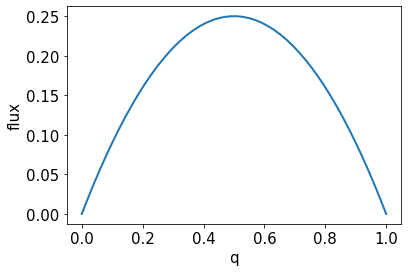

In [53]:
plt.figure()
plt.plot(q, f, linewidth = 2)
plt.xlabel('q')
plt.ylabel('flux')
plt.show()

### shock waves (traffic jams)

In [54]:
m = 400
dx = 1./m

x = np.arange(- dx/2, 1. + dx/2, dx)

t = 0. # Initial time
T = 0.5 # Final time
dt = 0.9 * dx  # Time step

Q = 0.9 * np.exp(-100 * (x-0.5)**2)
Qnew = np.empty(Q.shape)
QQ = [Q]

while t < T:
    
    Qnew[1:-1] = 0.5 * (Q[:-2]+Q[2:]) - 0.5*dt/dx * (Q[2:]*(1-Q[2:])-Q[:-2]*(1-Q[:-2]))
    
    Q = Qnew.copy()
    
    Q[0] = Q[-2]
    Q[-1] = Q[1]
    t = t + dt
    QQ.append(Q)

In [55]:
len(QQ)

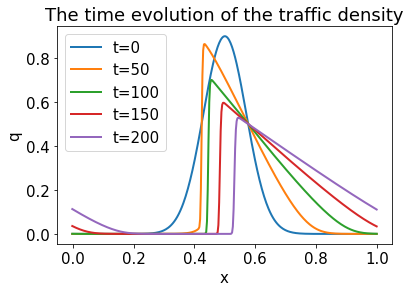

In [56]:
plt.figure()
plt.xlabel('x')
plt.ylabel('q')
plt.title('The time evolution of the traffic density')
for i in range(len(QQ)):
    if i%50 == 0:
        plt.plot(x, QQ[i], linewidth = 2, label="t=%d"%i)

plt.legend()
plt.show()

## Non-linear convection

We consider the equation

$$\frac{\partial{u}}{\partial{t}} + u \frac{\partial{u}}{\partial{x}} = 0.$$

Then forward difference in time and backward difference in space are conducted, which leads to 

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n).$$

In [57]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

In [58]:
nx = 41
dx = 2. / (nx-1)
steps = 20
dt = .025  #dt is the amount of time each timestep covers (delta t)

x = np.linspace(0, 2, nx)

u = np.ones(nx)      #as before, we initialize u with every value equal to 1.
u[int(.5/dx):int(1./dx + 1)] = 2  #then set u = 2 between 0.5 and 1 as per our I.C.s

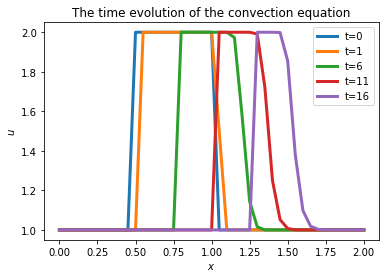

In [59]:
un = np.ones(nx) #initialize our placeholder array un, to hold the time-stepped solution

fig = plt.figure()
plt.plot(x, u, linewidth=3, label="t=%d"%0)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The time evolution of the convection equation')
for j in range(steps):
    un = u.copy()
    for i in range(1, nx):
        u[i] = un[i] - un[i] * dt/dx * (un[i] - un[i-1])
    if j%5 == 0:
        plt.plot(x, u, linewidth=3, label="t=%d"%(j+1))

plt.legend()
plt.show()

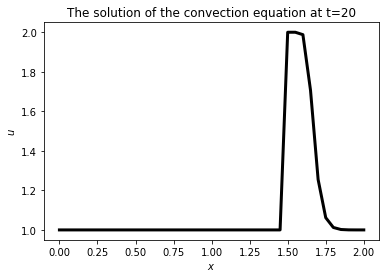

In [60]:
plt.figure()
plt.plot(x, u, 'k-', linewidth=3)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The solution of the convection equation at t=%d'%steps)
plt.show()

## Burgers' equation

For $\nu << 1$, the dissipative term only becomes important when the solution gets very steep; it prevents the formation of shock waves (discontinuities).

$$u_t + u u_x = \nu u_{xx}$$

Discretization is used, which leads to

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{\Delta x^2},$$

then, we obtain

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2} (u_{i+1}^n - 2 u_i^n + u_{i-1}^n).$$

### initial condition

$$u_0 = -\frac{2\nu}{\phi}\phi_x + 4$$

where

$$\phi = exp\left(\frac{-x^2}{4\nu}\right) + exp\left(\frac{-(x-2\pi)^2}{4\nu}\right).$$

This has an analytical solution

$$u = -\frac{2\nu}{\phi}\phi_x + 4$$

where

$$\phi = exp\left(\frac{-(x-4t)^2}{4\nu (t+1)}\right) + exp\left(\frac{-(x-4t-2\pi)^2}{4\nu (t+1)}\right).$$

### boundary condition (periodic)

$$u(0) = u(2\pi)$$

In [61]:
%matplotlib inline
import numpy as np

import sympy as sym
from sympy.utilities import lambdify

sym.init_printing(use_latex=True)

In [62]:
x, t, nu = sym.symbols('x t nu')

phi = sym.exp(-(x-4*t)**2 / (4*nu*(t+1))) + sym.exp(-(x-4*t-2*sym.pi)**2 / (4*nu*(t+1)))

In [63]:
phi

In [64]:
phiprime = phi.diff(x)

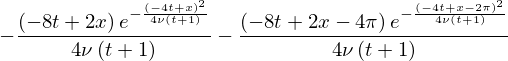

In [65]:
phiprime

In [66]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


In [67]:
u = -2 * nu * (phiprime/phi) + 4

In [68]:
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


In [69]:
ufunc = lambdify((x, t, nu), u)

In [70]:
print(ufunc(4, 1, 3))

3.49170664206445


In [71]:
###variable declarations
nx = 101
steps = 100
dx = 2*np.pi / (nx-1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2*np.pi, nx)

t = 0
u = np.asarray([ufunc(x0, t, nu) for x0 in x])

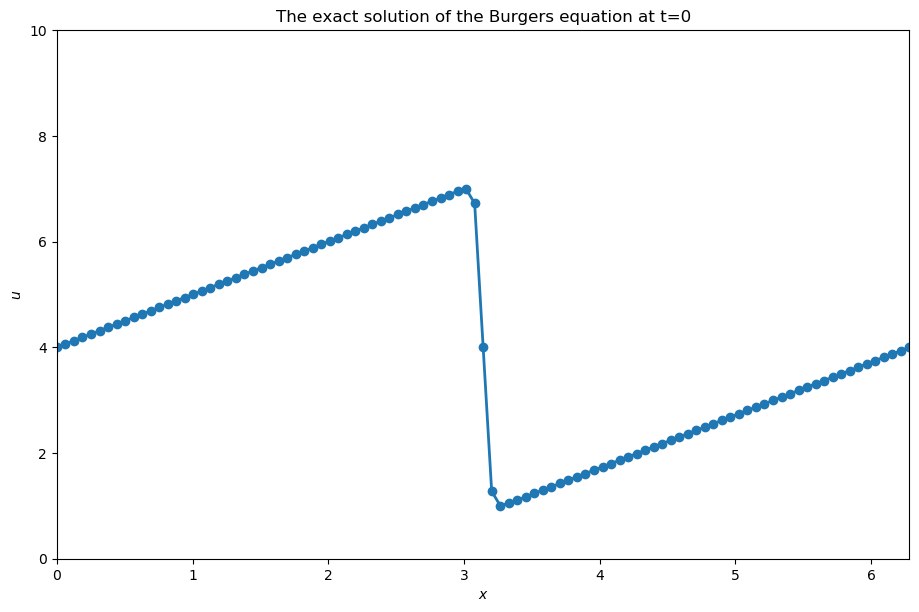

In [72]:
plt.figure(figsize = (11, 7), dpi = 100)
plt.plot(x, u, marker = 'o', lw = 2)
plt.xlim([0, 2*np.pi])
plt.ylim([0, 10])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The exact solution of the Burgers equation at t=%d'%0)
plt.show()

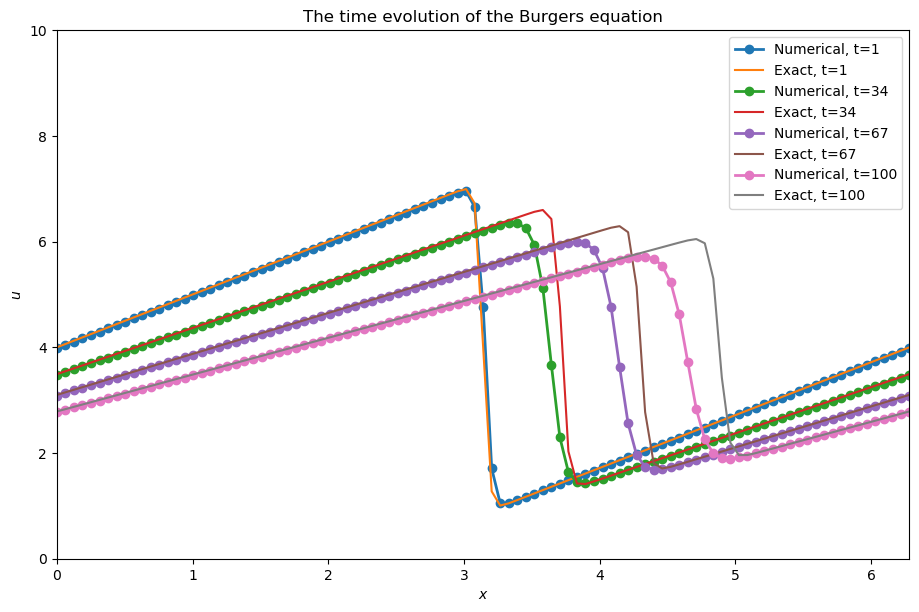

In [73]:
un = np.empty(nx)

plt.figure(figsize=(11, 7), dpi = 100)
#plt.plot(x, u, marker='o', lw=2, label='Numerical, t=%d'%0)
#plt.plot(x, u, label='Exact, t=%d'%0)
plt.xlim([0, 2*np.pi])
plt.ylim([0, 10])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'The time evolution of the Burgers equation')
for j in range(steps):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt/dx *(un[i]-un[i-1]) + nu * dt/dx**2 * (un[i+1] - 2*un[i] + un[i-1])
    
    u[0] = un[0] - un[0] * dt/dx * (un[0] - un[-2]) + nu * dt/dx**2 * (un[1] - 2*un[0] + un[-2])
    u[-1] = u[0]
    
    u_exact = np.asarray([ufunc(xi, j*dt, nu) for xi in x])
    
    if j%33 == 0:
        plt.plot(x, u, marker='o', lw=2, label='Numerical, t=%d'%(j+1))
        plt.plot(x, u_exact, label='Exact, t=%d'%(j+1))
        
plt.legend()
plt.show()

In [74]:
print(np.linalg.norm(u_exact-u,2)/np.linalg.norm(u_exact,2))

0.16055191016197604
